In [94]:
# --- 1. SETUP AND IMPORTS ---
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from google.colab import files
import numpy as np
import warnings
import matplotlib.pyplot as plt # Added for plotting
import seaborn as sns           # Added for heatmap

# Suppress ConvergenceWarning for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
print("✅ Libraries imported.")

# --- 2. FILE UPLOAD ---
train_file = 'KDDTrain+.txt'
test_file = 'KDDTest+.txt'

# --- 3. PREPARE ENCODERS AND METADATA ---
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'attack', 'difficulty'
]
categorical_cols = ['protocol_type', 'service', 'flag']
# The numerical_cols list will be redefined after feature selection in the next step

# Fit encoders on all possible categories from both files
df_train_cat = pd.read_csv(train_file, header=None, names=columns, usecols=categorical_cols)
df_test_cat = pd.read_csv(test_file, header=None, names=columns, usecols=categorical_cols)
combined_cat = pd.concat([df_train_cat, df_test_cat], ignore_index=True)

protocol_encoder = LabelEncoder().fit(combined_cat['protocol_type'])
service_encoder = LabelEncoder().fit(combined_cat['service'])
flag_encoder = LabelEncoder().fit(combined_cat['flag'])

all_classes = np.array([0, 1])
chunksize = 700 # Use a larger, more stable chunksize

print("\n✅ Common setup complete. You can now run any of the model blocks below.")

✅ Libraries imported.

✅ Common setup complete. You can now run any of the model blocks below.


🔬 Performing feature selection based on correlation...


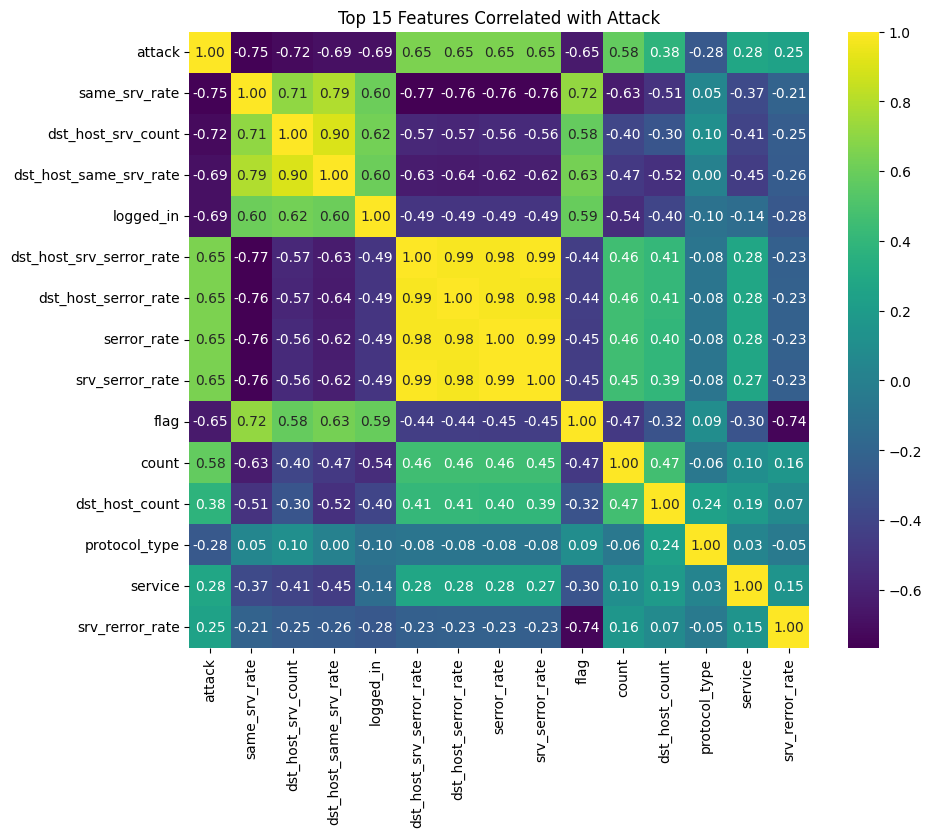

🔥 Removed 8 features with absolute correlation < 0.01.
✅ Kept 33 features for training.
   -> Features Removed: ['num_shells', 'land', 'src_bytes', 'dst_bytes', 'num_failed_logins', 'urgent', 'is_host_login', 'srv_count']

✅ Feature selection complete.


In [95]:
# --- 2.1. FEATURE SELECTION BASED ON CORRELATION ---

print("🔬 Performing feature selection based on correlation...")

# Load the entire training dataset for correlation analysis
df_full = pd.read_csv(train_file, header=None, names=columns)

# Preprocess a copy of the dataframe for correlation calculation
df_corr = df_full.copy()
df_corr['protocol_type'] = protocol_encoder.transform(df_corr['protocol_type'])
df_corr['service'] = service_encoder.transform(df_corr['service'])
df_corr['flag'] = flag_encoder.transform(df_corr['flag'])
df_corr['attack'] = df_corr['attack'].apply(lambda x: 0 if x == 'normal' else 1)

# Calculate correlation matrix
correlation_matrix = df_corr.drop(columns=['difficulty']).corr()

# Get correlations of features with the target variable 'attack'
target_correlation = correlation_matrix['attack'].abs().sort_values(ascending=False)

# --- Visualize the Correlation Heatmap ---
plt.figure(figsize=(10, 8))
top_features = target_correlation.head(15).index
sns.heatmap(df_corr[top_features].corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Top 15 Features Correlated with Attack')
plt.show()


# --- Eliminate Features with Low Correlation ---
# Set a more lenient threshold to keep more potentially useful features.
CORRELATION_THRESHOLD = 0.01

# Identify features to remove
features_to_remove = target_correlation[target_correlation < CORRELATION_THRESHOLD].index.tolist()

# Define the final list of numerical and categorical columns for the model
all_features = [col for col in columns if col not in ['attack', 'difficulty']]
final_features = [col for col in all_features if col not in features_to_remove]

# Redefine numerical_cols and categorical_cols based on the selected features
numerical_cols = [col for col in final_features if col not in ['protocol_type', 'service', 'flag']]
categorical_cols = [col for col in final_features if col in ['protocol_type', 'service', 'flag']]


print(f"🔥 Removed {len(features_to_remove)} features with absolute correlation < {CORRELATION_THRESHOLD}.")
print(f"✅ Kept {len(final_features)} features for training.")
print("   -> Features Removed:", features_to_remove)
print("\n✅ Feature selection complete.")

In [96]:
# --- 3. MODEL INITIALIZATION (Corrected Tuning) ---

# StandardScaler to scale numerical features.
scaler = StandardScaler()

# Define the models
models = {
    "Online Logistic Regression (SGD)": SGDClassifier(loss='log_loss', random_state=42, learning_rate='adaptive', eta0=0.01),

    # Tuned MLP: Smaller, more efficient architecture compatible with partial_fit
    "Multi-layer Perceptron": MLPClassifier(
        # The most important change for better performance
        hidden_layer_sizes=(700, 70),

        # This adjusts the learning rate when training plateaus and works with partial_fit
        learning_rate='adaptive',

        # REMOVED: early_stopping=True is not compatible with partial_fit

        activation='relu',
        solver='adam',
        random_state=42,
        learning_rate_init=0.01,
        alpha=0.001
    ),

    "Gaussian Naive Bayes": GaussianNB()
}

print("✅ Models and preprocessors initialized.")

✅ Models and preprocessors initialized.


In [97]:
# --- 4. ONLINE TRAINING LOOP ---

print("🚀 Starting Online Training...")

# Read the training data in chunks to simulate a stream
for chunk in pd.read_csv(train_file, header=None, names=columns, chunksize=chunksize):
    # --- Preprocessing the chunk ---
    for col in categorical_cols:
        if col == 'protocol_type':
            chunk[col] = protocol_encoder.transform(chunk[col])
        elif col == 'service':
            chunk[col] = service_encoder.transform(chunk[col])
        elif col == 'flag':
            chunk[col] = flag_encoder.transform(chunk[col])

    y_chunk = chunk['attack'].apply(lambda x: 0 if x == 'normal' else 1)

    # --- FIX: Create an explicit copy to avoid the SettingWithCopyWarning ---
    X_chunk = chunk[final_features].copy()

    # Convert numerical columns to float
    X_chunk[numerical_cols] = X_chunk[numerical_cols].astype(float)

    # Scale numerical features.
    scaler.partial_fit(X_chunk[numerical_cols])
    X_chunk[numerical_cols] = scaler.transform(X_chunk[numerical_cols])

    # --- Incremental Training ---
    for model_name, model in models.items():
        model.partial_fit(X_chunk, y_chunk, classes=all_classes)

print("✅ Online Training Complete.")

🚀 Starting Online Training...
✅ Online Training Complete.


In [98]:
# --- 5. ONLINE EVALUATION ---

print("\n🔬 Starting Online Evaluation on the test set...")

results = {}

for model_name, model in models.items():
    all_y_true = []
    all_y_pred = []

    for chunk in pd.read_csv(test_file, header=None, names=columns, chunksize=chunksize):
        # --- Preprocessing the test chunk ---
        for col in categorical_cols:
            if col == 'protocol_type':
                chunk[col] = protocol_encoder.transform(chunk[col])
            elif col == 'service':
                chunk[col] = service_encoder.transform(chunk[col])
            elif col == 'flag':
                chunk[col] = flag_encoder.transform(chunk[col])

        y_true = chunk['attack'].apply(lambda x: 0 if x == 'normal' else 1)

        # --- FIX: Create an explicit copy to avoid the SettingWithCopyWarning ---
        X_test_chunk = chunk[final_features].copy()

        # Convert numerical columns to float
        X_test_chunk[numerical_cols] = X_test_chunk[numerical_cols].astype(float)

        # Use the already fitted scaler to transform the test data
        X_test_chunk[numerical_cols] = scaler.transform(X_test_chunk[numerical_cols])

        # --- Prediction ---
        y_pred = model.predict(X_test_chunk)

        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)

    # --- Calculate overall metrics ---
    accuracy = accuracy_score(all_y_true, all_y_pred)
    precision = precision_score(all_y_true, all_y_pred, average='weighted', zero_division=0)
    recall = recall_score(all_y_true, all_y_pred, average='weighted', zero_division=0)
    f1 = f1_score(all_y_true, all_y_pred, average='weighted', zero_division=0)

    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }
    print(f"  - Evaluation for {model_name} complete.")

print("✅ Online Evaluation Complete.")

# --- 6. DISPLAY RESULTS ---
print("\n--- 📊 Final Model Performance Comparison (Tuned) 📊 ---")
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='F1-Score', ascending=False)
print(results_df)


🔬 Starting Online Evaluation on the test set...
  - Evaluation for Online Logistic Regression (SGD) complete.
  - Evaluation for Multi-layer Perceptron complete.
  - Evaluation for Gaussian Naive Bayes complete.
✅ Online Evaluation Complete.

--- 📊 Final Model Performance Comparison (Tuned) 📊 ---
                                  Accuracy  Precision    Recall  F1-Score
Online Logistic Regression (SGD)  0.853265   0.852978  0.853265  0.852852
Multi-layer Perceptron            0.800967   0.848322  0.800967  0.799797
Gaussian Naive Bayes              0.770360   0.811677  0.770360  0.769368
